<a href="https://colab.research.google.com/github/doumoh/RIS_aided_communication/blob/main/Test_Ray_tracing_RIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os # Configure which GPU
if os.getenv("CUDA_VISIBLE_DEVICES") is None:
    gpu_num = 0 # Use "" to use the CPU
    os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

# Colab does currently not support the latest version of ipython.
# Thus, the preview does not work in Colab. However, whenever possible we
# strongly recommend to use the scene preview mode.
try: # detect if the notebook runs in Colab
    import google.colab
    no_preview = True # deactivate preview
except:
    if os.getenv("SIONNA_NO_PREVIEW"):
        no_preview = True
    else:
        no_preview = False

resolution = [480,320] # increase for higher quality of renderings

# Define magic cell command to skip a cell if needed
from IPython.core.magic import register_cell_magic
from IPython import get_ipython

@register_cell_magic
def skip_if(line, cell):
    if eval(line):
        return
    get_ipython().run_cell(cell)

# Set random seed for reproducibility
sionna.config.seed = 40
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm

from sionna import PI
from sionna.rt import load_scene, Transmitter, Receiver, RIS, PlanarArray, \
                      r_hat, normalize, Camera

In [37]:
# Load an empty scene and configure single linearly polarized antennas for
# all transmitters and receivers
scene = load_scene()
scene.frequency = 5.8e9 # Carrier frequency [Hz]
scene.tx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")
scene.rx_array = PlanarArray(1,1,0.5,0.5,"iso", "V")

# Place a transmitter far away from the RIS so that
# the incoming wave is almost planar
tx = Transmitter("tx", [-2.5,3,1.5])
rx = Receiver("rx", [3,0,3])
scene.add(tx)
scene.add(rx)

# Configure RIS in the x-z plane centered at the origin
width = 8 * scene.wavelength # Width [m] as described in [1]
num_rows = num_cols = int(width/(0.5*scene.wavelength))

ris = RIS(name="ris",
          position=[0.5,0,1.5],
          orientation=[0,-PI/2,0],
          num_rows=num_rows,
          num_cols=num_cols)
scene.add(ris)

In [33]:
source = tx.position # Location of the origin of the incoming ray
target = rx.position # Target position

# Configure the RIS as focusing lens
ris.focusing_lens(source, target)

In [40]:
phase_profile_np = ris.phase_profile.values.numpy()

# Set all values to 0 initially
phase_profile_np[:] = 0

# Set the first 3 columns to 180 degrees
#phase_profile_np[:, 3:5, :] = 180
#phase_profile_np[:, 8:10,:] = 180
#phase_profile_np[:, 13:15,:] = 180
#phase_profile_np[:, :,:5] = 180
#phase_profile_np[:, :,11:] = 180

""" configuration for state (a) """
phase_profile_np[:, :,3:5] = 180
phase_profile_np[:, :,8:10] = 180
phase_profile_np[:, :,13:15] = 180





# Convert back to a TensorFlow tensor and reassign
ris.phase_profile.values = tf.convert_to_tensor(phase_profile_np, dtype=tf.float32)
print(ris.phase_profile.values)

tf.Tensor(
[[[  0.   0.   0. 180. 180.   0.   0.   0. 180. 180.   0.   0.   0. 180.
   180.   0.]
  [  0.   0.   0. 180. 180.   0.   0.   0. 180. 180.   0.   0.   0. 180.
   180.   0.]
  [  0.   0.   0. 180. 180.   0.   0.   0. 180. 180.   0.   0.   0. 180.
   180.   0.]
  [  0.   0.   0. 180. 180.   0.   0.   0. 180. 180.   0.   0.   0. 180.
   180.   0.]
  [  0.   0.   0. 180. 180.   0.   0.   0. 180. 180.   0.   0.   0. 180.
   180.   0.]
  [  0.   0.   0. 180. 180.   0.   0.   0. 180. 180.   0.   0.   0. 180.
   180.   0.]
  [  0.   0.   0. 180. 180.   0.   0.   0. 180. 180.   0.   0.   0. 180.
   180.   0.]
  [  0.   0.   0. 180. 180.   0.   0.   0. 180. 180.   0.   0.   0. 180.
   180.   0.]
  [  0.   0.   0. 180. 180.   0.   0.   0. 180. 180.   0.   0.   0. 180.
   180.   0.]
  [  0.   0.   0. 180. 180.   0.   0.   0. 180. 180.   0.   0.   0. 180.
   180.   0.]
  [  0.   0.   0. 180. 180.   0.   0.   0. 180. 180.   0.   0.   0. 180.
   180.   0.]
  [  0.   0.   0. 180. 180.   0.

<ipython-input-42-3c581f0f02d5>:49: RuntimeWarning: divide by zero encountered in log10
  E_vals_dB = 20 * np.log10(E_vals / max_E)


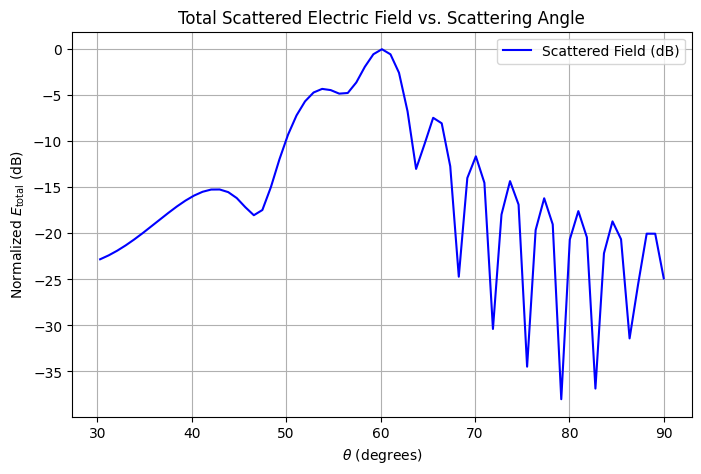

In [42]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

class RISModel:
    def __init__(self, M=16, N=16, wavelength=0.05172, tx_pos=tx.position):
        self.M = M  # Number of unit cells along x-axis
        self.N = N  # Number of unit cells along y-axis
        self.k = 2 * np.pi / wavelength  # Wavenumber
        self.tx_pos = np.array(tx_pos)  # Transmitter position
        self.eta0 = 120 * np.pi  # Free-space impedance
        self.Pt = 1  # Transmit power
        self.Gt = 100 # Reciever antenna gain
        self.Gr = 100  # Transmit antenna gain
        self.A_physical = self.Gr * wavelength ** 2 / 4 * np.pi # Approximate physical area


    def field_at_points(self, scene, tx, ris, theta_vals, r_distance):
        E_vals = []
        E_phase = []

        for theta in np.radians(theta_vals):
            rx.position = (r_distance * np.cos(theta), 0, r_distance * np.sin(theta)) # Scanning along with arc of R = 3 m
            # Alternative for azimuthal scanning:
            # rx_position = (r_distance * np.cos(theta), r_distance * np.sin(theta), 0)


            paths = scene.compute_paths(los=False, reflection=False, ris=True)
            a = tf.squeeze(paths.cir()[0])

            e = (4 * np.pi / scene.wavelength) * tx.position[1] * tf.abs(a) # Compute E

            e_phase = tf.math.angle(a)
            E_vals.append(e)
            E_phase.append(e_phase)

        # Convert to NumPy array and remove NaNs
        E_vals = np.array(E_vals)

        E_phase = np.array(E_phase)
        E_vals = np.nan_to_num(E_vals, nan=0.0)  # Replace NaNs with 0
        E_phase = np.nan_to_num(E_phase, nan=0.0)
        E_total_magnitude = np.sum(np.array(E_vals))
        E_total_phase = np.sum(np.array(E_phase))

        # Avoid division by zero before computing dB
        max_E = np.max(E_vals)
        if max_E > 0:
            E_vals_dB = 20 * np.log10(E_vals / max_E)
        else:

            E_vals_dB = np.zeros_like(E_vals)  # Avoid NaNs in plot


        # Plot results
        plt.figure(figsize=(8, 5))
        plt.plot(theta_vals, E_vals_dB, color="blue", label="Scattered Field (dB)")
        plt.xlabel(r"$\theta$ (degrees)")
        plt.ylabel(r"Normalized $E_{\text{total}}$ (dB)")
        plt.title("Total Scattered Electric Field vs. Scattering Angle")
        plt.legend()
        plt.grid()
        plt.show()

        Rt=np.linalg.norm(np.array(tx.position[1]) - np.array(ris.position[1])) # Distance between Transmitter and RIS
        phi_sc_tot = np.angle(E_total_phase)  # Phase of the total scattered field
        E_inc = np.sqrt(self.eta0 * self.Gt * self.Pt / (2 * np.pi)) * np.exp(-1j * self.k * Rt) / Rt # E_inc eq (21)
        sigma_s = (4 * np.pi * Rt**2) * ((E_total_magnitude / E_inc) ** 2) * np.exp(2j * (phi_sc_tot + self.k * Rt - np.angle(E_inc))) # E_inc eq (20)

        G = np.abs(sigma_s) / self.A_physical # Gain from eq (19)

        return E_total_magnitude,phi_sc_tot,sigma_s,G

# Example usage:
theta_vals = np.linspace(-90, 90, 200)  # Angle range for scanning
ris_model = RISModel()

E_vals,E_phase,sigma,g = ris_model.field_at_points(scene, tx, ris, theta_vals,3)


In [ ]:
""" The result does not match with the fig .8 in the paper"""

In [53]:
print(E_vals,np.rad2deg(E_phase),sigma,g)
print(20*np.log10(np.abs(sigma)))
print(20*np.log10(E_vals))
print(20*np.log10(g))



0.47746664 180.0 (0.03808466296428117+0.006731256605125858j) 0.18408686029959198
-28.251405911137052
-6.421139240264893
-14.699544186794737
